# Sex differences in functional cortical organization (Serio et al.)

## Geodesic Distance Data

Retrieve geodesic distance data from /data/p_02721/ directory and store in my project directory (/data/p_02667/sex_diff_gradients/data/geodesic_distance/) the cleaned output:
- file_failed.txt: subjects that do not have geodesic distance data
- HCP_sub_list_geodesic.csv: list of subjects with geodesic distance data
- mean_top_geodesic_distances.csv: the mean of top 10% of distances per parcel per subject (shape: N x 400)
- geodesic_distances_matrices.mat: matrices of the raw geodesic distances (shape: N x 400 x 400)

## Load packages

In [1]:
# General
import numpy as np
import pandas as pd
import os
import csv

# Computing
import scipy.io
from heapq import nlargest  # gives you the largest values of a list

# Visualization
import matplotlib.pyplot as plt

## Define directories

In [2]:
codedir = os.path.abspath('')  # obtain current direction from which script is runnning

datadir = '/data/p_02667/sex_diff_gradients/data/'
datadir_geodesic = '/data/p_02721/geodesic_HCP/mica_pipe/output/micapipe/'

dataout = '/data/p_02667/sex_diff_gradients/data/geodesic_distance/'

In [3]:
path_list = os.listdir(datadir_geodesic)
path_list.sort()

## Data

### Load fc data (needed to compute mean geodesic distance for top 10% of fc connections)

In [4]:
# fc matrices
scipy.io.whosmat(datadir+'fc_matrices/fc_matrices.mat')

[('HCP_fc_matrices', (1014, 400, 400), 'double'),
 ('HCP_sub_list_fc', (1014,), 'char'),
 ('GSP_fc_matrices', (1568, 400, 400), 'double'),
 ('GSP_sub_list_fc', (1568,), 'char')]

In [5]:
# taking the list of subjects that have fc data
HCP_sub_list_fc = scipy.io.loadmat(datadir+'fc_matrices/fc_matrices.mat')['HCP_sub_list_fc']

# taking the fc matrices from the mat file
fc_matrices_full = scipy.io.loadmat(datadir+'fc_matrices/fc_matrices.mat')['HCP_fc_matrices']

### Retrieve geodesic distance data from original directory and shaping it into a readable format (from txt file to 400x400 matrix) whilst removing medial mask (original number of datapoints 402x402)

In [6]:
# list that will contain the matrices of the raw geodesic distance (pre-computed pro hemisphere - cross hemisphere cells are coded with 0)
geodesic_distances_matrices = []

# list that will contain the subjects IDs with geodesic distance data
HCP_sub_list_geodesic = []


# iterate over subjects in directory
for dir in path_list:
    if os.path.exists(datadir_geodesic+dir+'/ses-01/anat/surfaces/geo_dist/'+dir+'_ses-01_space-fsnative_atlas-schaefer-400_GD.txt'):
        
        print('---------------- executing: '+dir+' ----------------')

        ### save subject ID to list of subjects with geodesic distance data (save just the number (removing "sub" before "-")
        HCP_sub_list_geodesic.append(dir.split("-")[1])


        ### Get geodesic distance data

        # temporary list for each subject containing a matrix of the raw geodesic distances
        temp_matrix_geod_list = []

        # read txt file
        reader = csv.reader(open(datadir_geodesic+dir+'/ses-01/anat/surfaces/geo_dist/'+dir+'_ses-01_space-fsnative_atlas-schaefer-400_GD.txt'), delimiter="\t")

        # creating a counter for index
        count_i = 0

        # iterate over each row of the text file
        for row in reader:

            # there are 402 values instead of 400 -> indices 0 and 201 are medial wall masks so need to be removed -> only include the rest
            if count_i != 0 and count_i != 201:

                # data is separated by space so need to split by space to make each number an element of the list
                splitted_row = row[0].split(" ")

                # convert every number into a float (from string)
                float_splitted_row = [float(current_integer) for current_integer in splitted_row]

                # there are 402 values instead of 400 -> indices 0 and 201 are medial wall masks so need to be removed -> only include the rest
                float_splitted_row_corrected = float_splitted_row[1:201]+float_splitted_row[202:402]

                # append the whole raw geodesic distances that will constitute a geodesic distance matrix
                temp_matrix_geod_list.append(float_splitted_row_corrected)

            # +1 to counter
            count_i += 1

        # append current subject's matrix of raw geodesic distances to list containing all subjects
        geodesic_distances_matrices.append(temp_matrix_geod_list)
        

            
    else:
        failed = dataout + 'file_failed.txt'
        fail_file = open(failed, 'a')
        fail_file.write(dir+'\n')
        fail_file.close()
        print('---------------- '+dir+' does not have geodesic distance data ----------------') 
        
        
# transform lists to array format
geodesic_distances_matrices = np.array(geodesic_distances_matrices)

---------------- micapipe_processed_sub.csv does not have geodesic distance data ----------------
---------------- pipeline-description.json does not have geodesic distance data ----------------
---------------- sub- does not have geodesic distance data ----------------
---------------- sub-100004 does not have geodesic distance data ----------------
---------------- executing: sub-100206 ----------------
---------------- executing: sub-100307 ----------------
---------------- executing: sub-100408 ----------------
---------------- sub-100601 does not have geodesic distance data ----------------
---------------- executing: sub-100610 ----------------
---------------- executing: sub-101006 ----------------
---------------- executing: sub-101107 ----------------
---------------- sub-101208 does not have geodesic distance data ----------------
---------------- executing: sub-101309 ----------------
---------------- executing: sub-101410 ----------------
---------------- sub-101612 does no

#### Check output

In [7]:
len(HCP_sub_list_geodesic)

1109

In [8]:
geodesic_distances_matrices.shape

(1109, 400, 400)

geodesic distrances available only within hemisphere (inter hemispheric distances coded as zero)

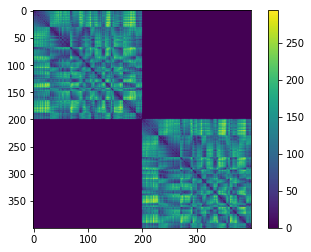

In [9]:
plt.imshow(geodesic_distances_matrices[0])
plt.colorbar()
plt.show()

### Get subsamples of fc and geodesic distance that match

#### Make a subject list that has fc and geodesic distance data

In [10]:
HCP_sub_list_fc_geo = set.intersection(set(HCP_sub_list_fc),set(HCP_sub_list_geodesic))
HCP_sub_list_fc_geo = list(HCP_sub_list_fc_geo)
HCP_sub_list_fc_geo.sort()
len(HCP_sub_list_fc_geo)

1010

### Get subsample of functional and geodesic distance data that has data of both (matching HCP_sub_list_fc_geo)

#### Geodesic distance

In [11]:
# list that will contain the geodesic distance matrices in for sample HCP_sub_list_fc_geo
geodesic_distances_matrices_corrected = []

for i in range(len(HCP_sub_list_geodesic)):
    if HCP_sub_list_geodesic[i] in HCP_sub_list_fc_geo:
        
        # append this subjects' list of mean top geodesic distances to the list of mean of the top geodesic distances in final sample
        geodesic_distances_matrices_corrected.append(geodesic_distances_matrices[i])
        
    
geodesic_distances_matrices_corrected = np.array(geodesic_distances_matrices_corrected)

In [12]:
geodesic_distances_matrices_corrected.shape

(1010, 400, 400)

#### Functional connectivity

In [13]:
# list that will contain the fc matrices in for sample HCP_sub_list_fc_geo
fc_matrices_corrected = []

for i in range(len(HCP_sub_list_fc)):
    if HCP_sub_list_fc[i] in HCP_sub_list_fc_geo:
        
        # append this subjects' list of mean top geodesic distances to the list of mean of the top geodesic distances in final sample
        fc_matrices_corrected.append(fc_matrices_full[i])
        
    
fc_matrices_corrected = np.array(fc_matrices_corrected)

In [14]:
fc_matrices_corrected.shape

(1010, 400, 400)

## Compute mean geodesic distance (for top 10% functional (!) connections) per parcel for all subjects

In [15]:
# list that will contain the mean top geodesic distances for all subjects (N x 400)
mean_geodesic_distances = []


# iterate over subjects
for i in range(len(HCP_sub_list_fc_geo)):

    # temporary list for each subject's mean top geodesic distances
    sub_mean_geodesic_distances = []

    # iterate over each row of the subject's geodesic distance 400x400 matrix 
    for j in range(len(geodesic_distances_matrices_corrected[0])):

        # identify the indices of the top 10% functional connections (!) i.e., top 20 connections (10% of 200 (400/2) given that geodesic distance was calculated across single hemispheres only)
        # code explanation available at: https://www.educative.io/answers/how-to-get-indices-of-n-maximum-values-in-numpy-arrays
        # retrieving indices from subject i and row j of the fc matrix
        
        # if left hemisphere
        if j <= 199:
            # take top funnctional connections from left hemisphere
            indices_top_fc = np.argsort(fc_matrices_corrected[i][j][:200])[::-1][:20]
            
        else:
            # take top funnctional connections from right hemisphere (need to add 200 to the indices outputted given that we are taking them from 200-parcel right hemisphere but applying them to 400 array in geodesic_distances_matrices_corrected)
            indices_top_fc = 200 + np.argsort(fc_matrices_corrected[i][j][200:])[::-1][:20]
            

        # take the mean of the highest 10% (so 20) geodesic distances (!) for subject i and row j of the geodesic distance matrix
        mean_top_geo = np.mean(geodesic_distances_matrices_corrected[i][j][indices_top_fc])

        # append mean of top geodesic distances to the subject's temporary list
        sub_mean_geodesic_distances.append(mean_top_geo)

    # append current subject's list of mean of top geodesic distances to list containing all subjects
    mean_geodesic_distances.append(sub_mean_geodesic_distances)
            
            
mean_geodesic_distances = np.array(mean_geodesic_distances)

In [16]:
mean_geodesic_distances.shape

(1010, 400)

## Save output to geodesic distance directory

In [17]:
# subject list 
np.savetxt(dataout+'HCP_sub_list_geodesic.csv', 
           HCP_sub_list_fc_geo,
           delimiter =",", 
           fmt ='% s')

In [48]:
# geodesic distance matrices 

np.savetxt(dataout+'mean_geodesic_distances.csv', mean_geodesic_distances, delimiter=',', fmt = '%.16g', comments = '')